In [1]:
import ase
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import abtem
from abtem.bloch import BlochWaves, StructureFactor

# nicer formatting for online display of pandas dataframes
pd.set_option("display.float_format", "{:.3f}".format)
pd.set_option("display.max_columns", 15)
pd.set_option("display.max_rows", 8)

(examples:bloch_wave_quickstart)=
# Bloch wave quickstart

This is a short example of running an electron diffraction simulation of zirconium oxide. See our [tutorial](tutorials:bloch_wave) for a more in depth description of *ab*TEM's implementation of Bloch waves.

## Configuration

We start by (optionally) setting our configuration. See [documentation](reference:configuration) for details.

In [2]:
abtem.config.set(
    {
        "precision": "float64",
        "device": "cpu",
    }
)

## Atomic model

We import an atomic model of zirconium oxide from the [materials project](https://next-gen.materialsproject.org/materials/mp-2858). 

As opposed to multislice simulations, we should not repeat the atoms. Note also that simulating a non-orthogonal unit cell is not an issue with Bloch waves.

In [3]:
atoms = ase.io.read("data/ZrO2.cif")

We rotate the atoms by $90 \ \mathrm{deg}$ around $x$.

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

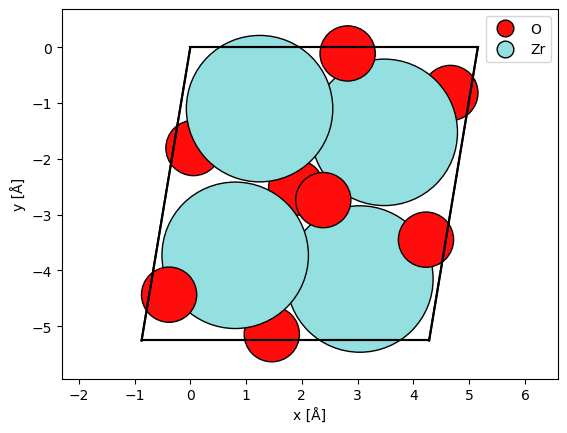

In [4]:
atoms.rotate("x", 90, rotate_cell=True)

abtem.show_atoms(atoms, legend=True, plane="xy")

## Structure factor

We create the `StructureFactor`, we should provide at least the atoms and the magnitude, `g_max`, of the maximum included reciprocal lattice vector. In addition we can select a parametrization and apply a Debye-Waller factor by setting `thermal_sigma`.

In [5]:
structure_factor = StructureFactor(
    atoms,
    g_max=8.0,
    parametrization="lobato",
    thermal_sigma=0.0,
)

## Bloch waves

We define the `BlochWaves` by providing the structure factor, an electron energy and the excitation error(`sg_max`). The included Bloch waves is those with a magnitude less than half `g_max` and with an excitation error (approximate distance to the Ewald) of less than `sg_max`.

In [6]:
sg_max = 0.16

bloch_waves = BlochWaves(structure_factor=structure_factor, energy=200e3, sg_max=sg_max)

print(structure_factor.g_max, bloch_waves.g_max)

8.0 4.0


The cost of Bloch wave simulation scales as cubed with the number of Bloch waves, hence we check the number here. For smaller systems $8000$ or more Bloch waves may be time-consuming.

In [7]:
print(len(bloch_waves))

2241


We also print the size of the structure matrix.

In [8]:
print(bloch_waves.structure_matrix_nbytes * 1e-9, "GB")

0.080353296 GB


We set up a simulation choosing a range of thicknesses in $\mathrm{Å}$.

In [9]:
thicknesses = np.arange(0, 1210, 10)

diffraction = bloch_waves.calculate_diffraction_patterns(thicknesses=thicknesses)

In [10]:
diffraction.compute()

[########################################] | 100% Completed | 4.27 sms


In [11]:
diffraction.metadata

{'energy': 200000.0,
 'sg_max': 0.16,
 'g_max': 4.0,
 'label': 'Intensity',
 'units': 'arb. unit'}

We show every $20$'th the results cropped to a maximum scattering vector of $k_{max}=1.5 \ \mathrm{Å}$.

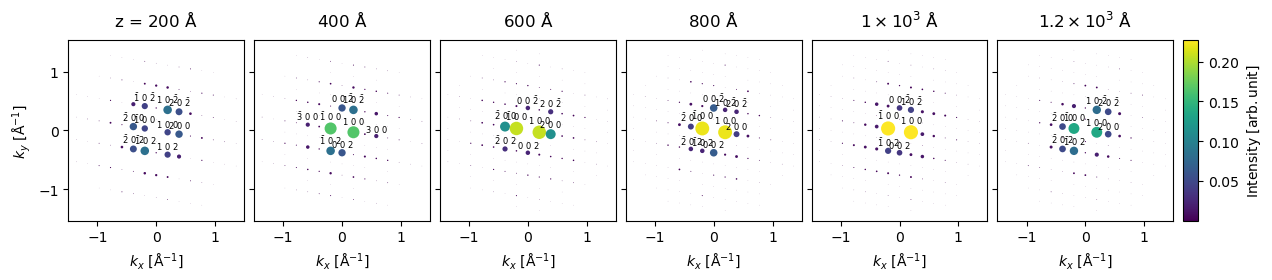

In [12]:
diffraction[20::20].block_direct().crop(k_max=1.5).show(
    explode=True,
    scale=0.12,
    figsize=(14, 5),
    annotation_kwargs={"threshold": 0.02, "fontsize":6},
    cbar=True,
    common_color_scale=True,
)

To perform a more quantitative analysis, we can get the data as pandas dataframe.

In [13]:
df = diffraction.remove_low_intensity(0.05).to_dataframe()
df

hkl,0 0 0,0 0 2,0 0 -2,1 0 0,1 0 -2,2 0 0,2 0 -2,-2 0 0,-2 0 2,-1 0 0,-1 0 2
z [Å],,,,,,,,,,,
0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
10.000,0.970,0.001,0.001,0.000,0.000,0.001,0.001,0.001,0.001,0.000,0.000
20.000,0.893,0.006,0.006,0.001,0.001,0.003,0.003,0.003,0.003,0.001,0.001
30.000,0.782,0.012,0.012,0.002,0.003,0.008,0.006,0.008,0.006,0.002,0.003
...,...,...,...,...,...,...,...,...,...,...,...
1170.000,0.040,0.015,0.015,0.157,0.101,0.059,0.031,0.059,0.031,0.157,0.101
1180.000,0.052,0.009,0.009,0.152,0.098,0.061,0.039,0.061,0.039,0.152,0.098
1190.000,0.068,0.005,0.005,0.145,0.090,0.058,0.046,0.058,0.046,0.145,0.090
1200.000,0.089,0.002,0.002,0.136,0.080,0.050,0.051,0.050,0.051,0.136,0.080


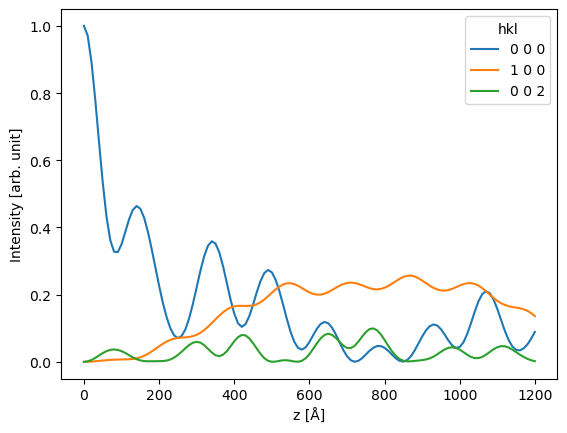

In [14]:
ax = df[["0 0 0", "1 0 0", "0 0 2"]].plot()
ax.set_ylabel("Intensity [arb. unit]");

## Single axis rotation

To simulate a rotated sample we use the `rotate` method obtaining a `BlochWavesEnsemble`.

In [15]:
rotations = np.linspace(0, 90, 6)

rotated_bloch_waves = bloch_waves.rotate("y", rotations, degrees=True)

rotated_bloch_waves.shape

(6,)

We setup the simulation for a single thickness.

In [16]:
rotated_diffraction = rotated_bloch_waves.calculate_diffraction_patterns(
    thicknesses=500.0
)

In [17]:
rotated_diffraction.compute(num_workers=3)

[########################################] | 100% Completed | 17.06 ss


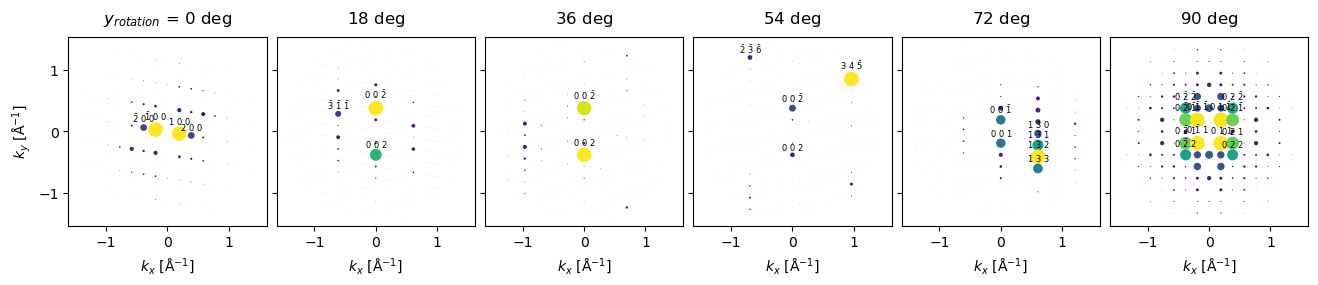

In [18]:
rotated_diffraction.block_direct().crop(k_max=1.5).show(
    explode=True,
    scale=0.12,
    figsize=(14, 5),
    annotation_kwargs={"threshold": 0.02, "fontsize":6},
    #cbar=True,
    #common_color_scale=True,
)

## Precession electron diffraction

In this example, we will calculate a precession electron diffraction pattern. We choose a precession angle of $50 \ \mathrm{mrad}$ and $100$ steps

In [19]:
precession_angle = 50 * 1e-3

azimuthal_angles = np.linspace(0, 2 * np.pi, num=100, endpoint=False)

tilt = precession_angle * np.stack(
    [np.cos(azimuthal_angles), np.sin(azimuthal_angles)], axis=1
)

tilt.shape

(100, 2)

The sample is rotated around $x$ then $y$ as given by each row of the tilt array. For more general and multidimensional rotations refer to [tutorial](tutorials:bloch_wave).

In [20]:
precessed_bloch_waves = bloch_waves.rotate("xy", tilt, degrees=False)

precessed_diffraction = precessed_bloch_waves.calculate_diffraction_patterns(
    thicknesses=300.0
)

*ab*TEM parallelizes over rotations, however, due to the large memory requirement of Bloch wave simulations the number of workers should be limited.

In [21]:
precessed_diffraction.compute(num_workers=4)

[########################################] | 100% Completed | 227.16 s


We integrate over the precession angles using the `mean` method.

In [22]:
integrated = precessed_diffraction.mean(0)

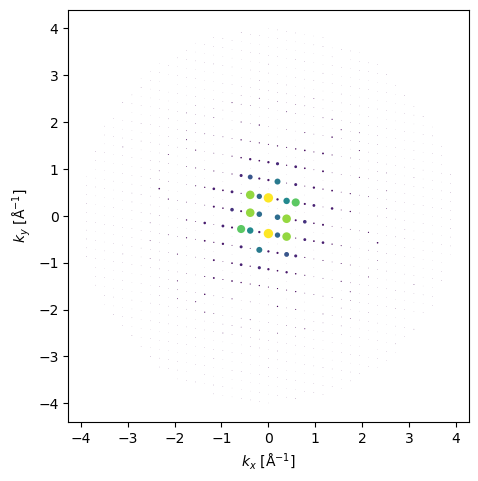

In [23]:
integrated.block_direct().show(annotations=False, scale=0.1)

In [24]:
kinematical bloch_waves.get_kinematical_diffraction_pattern().show(
    annotations=False, scale=0.1
)

SyntaxError: invalid syntax (581741875.py, line 1)

In [ ]:
{**{"a": 1}, **{"a": 2}}

In [ ]:
# this cell produces a thumbnail for the online documentation

visualization = integrated.block_direct().show(annotations=False, scale=0.15)
visualization.axis_off()
plt.savefig(
    "../thumbnails/bloch_wave_quickstart.png", bbox_inches="tight", pad_inches=0
)